Challenge Set 1

Topic:        Explore MTA turnstile data

Date:         1/13/2016

Name:         Justin Stewart


# Challenge 1:

Download a few MTA turnstile data files. Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row.

In [204]:
# !curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_160109.txt > mta_data_jan09.csv

In [210]:
# !curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_160102.txt > mta_data_jan02.csv

In [209]:
# !curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_151226.txt > mta_data_dec26.csv

In [212]:
# !curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_151219.txt > mta_data_dec19.csv

In [69]:
from dateutil.parser import parse
import matplotlib.pyplot as plt
import csv

In [70]:
def mta_csv_to_dict(path_to_csv):
    # open and pare the csv into a list of lists
    with open(path_to_csv) as csvfile:
        mta_reader = csv.reader(csvfile, delimiter=',')
        mta_rows = [[cell.strip() for cell in row] for row in mta_reader]
    assert mta_rows.pop(0) == ['C/A','UNIT','SCP','STATION','LINENAME','DIVISION',
                               'DATE','TIME','DESC','ENTRIES','EXITS']
    # writing data to a dictionary
    mta_dict = {}
    for row in mta_rows:
        key, val =  tuple(row[:4]), row[4:]
        mta_dict.setdefault(key,[]).append(val)
    return mta_dict

# Challenge 2

Let's turn this into a time series. For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries. This basically means keeping only the date, time, and entries field in each list.

First we create a new dictionary containing the same key and change the value to a list containing the resulting datetime object found by parseing to date and time feilds, and the cummulative value of entries at that key. 

In [31]:
mta_cummulative_timeseries = {key: [[parse(row[2]+' '+row[3]),int(row[5])] 
                                      for i, row in enumerate(val)] 
                                      for key,val in mta_dict.items()}

Then we create another dictionary, again using the same keys, but find the total entries per turnstyle by taking the difference between subsequent recordings.

In [ ]:
mta_timeseries = {key:[[val[i][0],
                        val[i+1][1]-val[i][1]] 
                  for i in range(len(val)-1)]
                  for key,val in mta_cummulative_timeseries.items()}

We can then combine the two operations into a method that can be used again later.

In [8]:
def mta_to_timeseries(mta_dict):
    mta_cummulative = {key: [[parse(row[2]+' '+row[3]),int(row[5])] 
                                      for i, row in enumerate(val)] 
                                      for key,val in mta_dict.items()}
    mta_timeseries = {key:[[val[i][0],
                        val[i+1][1]-val[i][1]] 
                  for i in range(len(val)-1)]
                  for key,val in mta_cummulative.items()}
    return mta_timeseries

# Challenge 3

Now we create the dictionary a third time (with same keys) but now have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day. These counts are for every n hours. (What is n?) We want total daily entries.

The value of n is 4 hours.

Completing this requires iterating through the items of the mta_timeseries and aggregating the values that are in the same day. Solution is given below. 

In [40]:
mta_daily_timeseries = {}
for key,time_counts in mta_timeseries.items():
    day_counts = {}
    for time,count in time_counts:
        date = time.date()
        day_counts[date] = day_counts.get(date,0) + count
    mta_daily_timeseries[key] = sorted(day_counts.items())

We can then wrap this into a function for later use.

In [7]:
def collapse_to_daily_timeseries(mta_timeseries):
    mta_daily_timeseries = {}
    for key,time_counts in mta_timeseries.items():
        day_counts = {}
        for time,count in time_counts:
            date = time.date()
            day_counts[date] = day_counts.get(date,0) + count
        mta_daily_timeseries[key] = sorted(day_counts.items())
    return mta_daily_timeseries

# Challenge 4

Plot the daily time series for a turnstile.

In [50]:
turnstyle = mta_daily_timeseries.items()[0][1]
dates,counts = zip(*turnstyle)

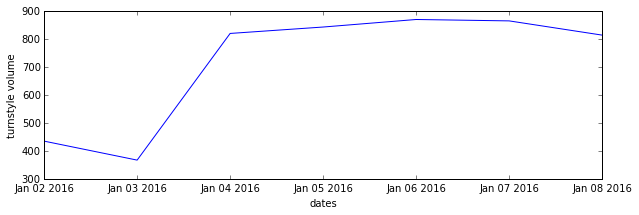

In [84]:
%matplotlib inline
plt.figure(figsize=(10,3))
plt.xlabel('dates')
plt.ylabel('turnstyle volume')
plt.plot(dates,counts)

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column. We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [70]:
unit_level = {}
for key, val in mta_daily_timeseries.items():
    a,b,_,s = key
    unit_key = (a,b,s)
    unit_val = {}
    for date,count in val:
        unit_val[date] = unit_val.get(date,0) + count
    unit_level[unit_key] = sorted(unit_val.items())


# Challenge 6

Using the same method, we can combine the dated enrty for each station and come up with a time series of [(date1, count1),(date2,count2),...] for each STATION.

In [71]:
station_level = {}
for key, val in unit_level.items():
    _,_,station = key
    station_val = {}
    for date,count in val:
        station_val[date] = station_val.get(date,0) + count
    station_level[station] = sorted(station_val.items())

For later use, we can create a function that takes the initial time series dictionary, and collapses it down to the station level.

In [6]:
def collapse_to_stations(mta_daily_timeseries):
    station_level = {}
    for key, val in mta_daily_timeseries.items():
        _,_,_,station = key
        station_val = {}
        for date,count in val:
            station_val[date] = station_val.get(date,0) + count
        station_level[station] = sorted(station_val.items())
    return station_level
    

# Challenge 7

Plot the time series for a station.

Set a variable to be an example station's time series.

In [80]:
station_counts = station_level.items()[0]
dates,counts =  zip(*station_counts[1])

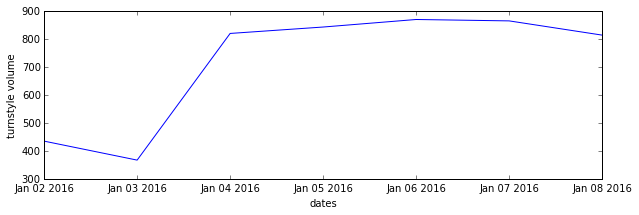

In [83]:
%matplotlib inline
plt.figure(figsize=(10,3))
plt.xlabel('dates')
plt.ylabel('turnstyle volume')
plt.plot(dates,counts)

# Challenge 8

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. ```plt.plot(week_count_list)``` for every ```week_count_list``` you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

The first task the problem necessitates is to download more data sets.

Then we need to utilize the functions created in the previous challenges to parse these new data sets for us to get them into a desired format. We can do this by composing the preceding functions tpgether.

In [4]:
def mta_data_to_station_ts(path_to_mta_data):
    mta_dict = mta_csv_to_dict(path_to_mta_data)
    mta_cumm_timeseries = mta_to_timeseries(mta_dict)
    mta_daily_timeseries = collapse_to_daily_timeseries(mta_cumm_timeseries)
    mta_stations = collapse_to_stations(mta_daily_timeseries)
    return mta_stations

Becareful running the below functions, will take time. 

In [35]:
# mta_jan09 = mta_data_to_station_ts('mta_data_jan09.csv')
# mta_jan02 = mta_data_to_station_ts('mta_data_jan02.csv')
# mta_dec26 = mta_data_to_station_ts('mta_data_dec26.csv')
# mta_dec19 = mta_data_to_station_ts('mta_data_dec19.csv')

Now after parsign all of the csv files for multiple weeks we will make week plots for each for one example station. 

In [259]:
ex_key = 'HARRISON'

In [265]:
days, countsj9 = zip(*sorted([(d.isoweekday(),c) for d,c in mta_jan09[ex_key]]))
days, countsj2 = zip(*sorted([(d.isoweekday(),c) for d,c in mta_jan02[ex_key]]))
days, countsd26 = zip(*sorted([(d.isoweekday(),c) for d,c in mta_dec26[ex_key]]))
days, countsd19 = zip(*sorted([(d.isoweekday(),c) for d,c in mta_dec19[ex_key]]))

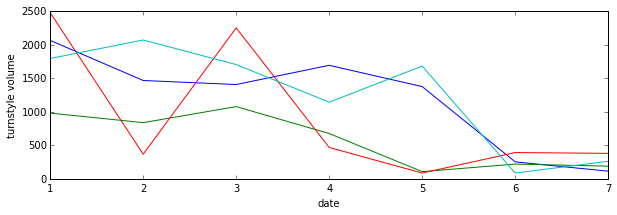

In [266]:
%matplotlib inline
plt.figure(figsize=(10,3))
plt.xlabel('date')
plt.ylabel('turnstyle volume')
plt.plot(days,countsj9)
plt.plot(days,countsj2)
plt.plot(days,countsd26)
plt.plot(days,countsd19)

# Challenge 9

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [32]:
def mta_station_totals(mta_stations):
    station_totals = {}
    for key,val in mta_stations.items():
        total = 0
        for row in val:
            total += row[1]
        station_totals[key] = total
    return station_totals

In [37]:
station_totals_jan09 = mta_station_totals(mta_jan09)
station_totals_jan02 = mta_station_totals(mta_jan02)

Collecting the dictionaries into a list.

In [54]:
list_of_mta_dicts = [station_totals_jan09,station_totals_jan02]

In [71]:
def mta_stations_combine_weeks(list_of_mta_dicts):
    station_totals = {}
    # need to take the intersection of all dictionaries keys
    all_keys = []
    for d in list_of_mta_dicts:
        all_keys += d.keys()
    common_keys = set(all_keys)
    # combine the list of dicts
    for d in list_of_mta_dicts:
        for k in common_keys:
            station_totals[k] = station_totals.get(k,0) + d[k]
    return station_totals

# Challenge 10

Make a single list of these total ridership values and plot it as a histogram. 

In [62]:
station_tots_over_weeks = mta_stations_combine_weeks(list_of_mta_dicts)
stations, counts = zip(*station_tots_over_weeks.items())

(array([   1.,    0.,    0.,   87.,  101.,  103.,   40.,   27.,    9.,    4.]),
 array([-27566. , -19701.8, -11837.6,  -3973.4,   3890.8,  11755. ,
         19619.2,  27483.4,  35347.6,  43211.8,  51076. ]),
 <a list of 10 Patch objects>)

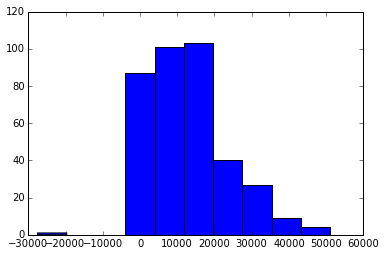

In [67]:
%matplotlib inline
plt.hist(counts)

In [ ]:
There looks like there were some data inputing erro